In [1]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



In [2]:

# Verzeichnis mit CSV-Dateien
file_path_pattern = r'..\..\..\data\attitude_roots_disapere\*.csv'

# Alle CSV-Dateien im Verzeichnis finden
csv_files = glob.glob(file_path_pattern)

# CSV-Dateien zu einem DataFrame kombinieren
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df = combined_df[['text', 'aspect']]
df = df.rename(columns={'aspect': 'labels', 'text': 'data'})
df = df.drop_duplicates(keep='first')

# Mindestlänge: mindestens 3 Worte
df = df[df['data'].apply(lambda x: len(str(x).split()) >= 3)]



print(len(df))


9129


In [3]:
# Zuerst in Trainings- und Testdaten aufteilen, bevor resampling durchgeführt wird
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

In [4]:
# Nun führen wir das Resampling nur auf den Trainingsdaten durch
aspects = [
    "asp_substance",
    "asp_originality",
    "asp_clarity",
    "asp_soundness-correctness",
    "asp_motivation-impact",
    "asp_meaningful-comparison",
    "asp_replicability",
    "arg_other"
]

for aspect in aspects:
    aspect_subset = train_df[train_df["labels"] == aspect]
    # Beispielsweise: resample identisch groß, aber Sie könnten das n anpassen, wenn nötig
    if len(aspect_subset) > 0:
        resampled = aspect_subset.sample(n=len(aspect_subset), replace=True, random_state=42)
        train_df = pd.concat([train_df, resampled], ignore_index=True)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

print("Train Labels:", train_df["labels"].unique())
print("Test Labels:", test_df["labels"].unique())


Train size: 12155
Test size: 1370
Train Labels: ['none' 'asp_originality' 'asp_clarity' 'asp_substance'
 'asp_replicability' 'asp_motivation-impact' 'asp_soundness-correctness'
 'asp_meaningful-comparison' 'arg_other']
Test Labels: ['asp_soundness-correctness' 'none' 'asp_substance'
 'asp_meaningful-comparison' 'asp_clarity' 'asp_motivation-impact'
 'asp_replicability' 'arg_other' 'asp_originality']


In [5]:
# Mapping für die Trainingsdaten
train_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(train_df["labels"].astype("category").cat.categories)),
    'labels': train_df["labels"].astype("category").cat.categories
})

print("Train Mapping:\n", train_mapping_df)

Train Mapping:
    encoded_cat                     labels
0            0                  arg_other
1            1                asp_clarity
2            2  asp_meaningful-comparison
3            3      asp_motivation-impact
4            4            asp_originality
5            5          asp_replicability
6            6  asp_soundness-correctness
7            7              asp_substance
8            8                       none


In [6]:
# Encode labels in train_df
train_df["encoded_cat"] = train_df["labels"].astype("category").cat.codes
train_texts = train_df["data"].to_list()  # Features (not tokenized yet)
train_labels = train_df["encoded_cat"].to_list()  # Labels

# Für Testdaten separat encodieren, um Konsistenz sicherzustellen
test_mapping_df = pd.DataFrame({
    'encoded_cat': range(len(test_df["labels"].astype("category").cat.categories)),
    'labels': test_df["labels"].astype("category").cat.categories
})
print("Test Mapping:\n", test_mapping_df)


Test Mapping:
    encoded_cat                     labels
0            0                  arg_other
1            1                asp_clarity
2            2  asp_meaningful-comparison
3            3      asp_motivation-impact
4            4            asp_originality
5            5          asp_replicability
6            6  asp_soundness-correctness
7            7              asp_substance
8            8                       none


In [7]:
test_df["encoded_cat"] = test_df["labels"].astype("category").cat.codes
data_test_texts = test_df["data"].to_list()  # Features (not tokenized yet)
data_test_labels = test_df["encoded_cat"].to_list()  # Labels

# Optional: weitere Aufteilung von Testdaten in Validation und finalen Test, wenn gewünscht.
val_texts, final_test_texts, val_labels, final_test_labels = train_test_split(
    data_test_texts, data_test_labels, test_size=0.9, random_state=0, shuffle=True
)


In [8]:
import tensorflow as tf
#Daten tokenisieren
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [9]:
# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
# import tensorflow as tf

# # Pfad zum Modell und Tokenizer
# model_path = r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\final_model"

# # Tokenizer und Modell laden
# tokenizer = DistilBertTokenizer.from_pretrained(model_path)
# model = TFDistilBertForSequenceClassification.from_pretrained(model_path, num_labels=9)

# # Optimizer einstellen
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

# # Modell kompilieren
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# print("Tokenizer and model loaded and compiled successfully!")


In [10]:
# Tokenisierung
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
final_test_encodings = tokenizer(final_test_texts, truncation=True, padding=True)

# Tensoren erstellen
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
final_test_labels = tf.convert_to_tensor(final_test_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(final_test_encodings), final_test_labels))


In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=1,
    batch_size=16,
    validation_data=val_dataset.batch(16),
    callbacks=[early_stopping]
)



307/760 [===========>..................] - ETA: 54:06 - loss: 1.4595 - accuracy: 0.5126

In [ ]:
save_directory = r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\roberta-base_multiclass_updated" 


In [ ]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('..\\..\\models\\attitude_classifier\\tokenizer_config.json',
 '..\\..\\models\\attitude_classifier\\special_tokens_map.json',
 '..\\..\\models\\attitude_classifier\\vocab.txt',
 '..\\..\\models\\attitude_classifier\\added_tokens.json')

In [ ]:
def predict_category(text):
    predict_input = tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [ ]:
# Vorhersagen auf Testdaten
pred = []
for v, y in zip(final_test_texts, final_test_labels):
    pred.append(predict_category(v))

confusion = confusion_matrix(final_test_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

In [ ]:
# Passen Sie die Klassenbezeichnungen an Ihre Kategorien an
class_names = ["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness", "substance", "None"]

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(final_test_labels, pred, target_names=class_names))


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained(save_directory)

model = TFDistilBertForSequenceClassification.from_pretrained(save_directory, num_labels=9)
 
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
# model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

# tokenizer = RobertaTokenizer.from_pretrained(save_directory, from_pt=True)
# model = TFRobertaForSequenceClassification.from_pretrained(save_directory, from_pt=True)

Some layers from the model checkpoint at C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\roberta-base_multiclass_e1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\roberta-base_multiclass_e1 and are newly initializ

In [ ]:
def predict_category(text):
    predict_input = tokenizer.encode(text,
    truncation=True,
    padding=True,
    return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [ ]:
# val_labels[0]
# val_texts

In [ ]:
# len(val_texts)

8 true:  tf.Tensor(1, shape=(), dtype=int32)
1 true:  tf.Tensor(0, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(7, shape=(), dtype=int32)
8 true:  tf.Tensor(3, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
3 true:  tf.Tensor(3, shape=(), dtype=int32)
1 true:  tf.Tensor(1, shape=(), dtype=int32)
6 true:  tf.Tensor(5, shape=(), dtype=int32)
2 true:  tf.Tensor(2, shape=(), dtype=int32)
5 true:  tf.Tensor(6, shape=(), dtype=int32)
1 true:  tf.Tensor(7, shape=(), dtype=int32)
2 true:  tf.Tensor(2, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
8 true:  tf.Tensor(8, shape=(), dtype=int32)
3 true:  tf.Tensor(3, shape=(), dtype=int32)
1 true:  tf.Tensor(1, shape=(), dtype=int32)
1 true:  tf.Tensor(1, shape=(), dtype=int32)
1 true:  t

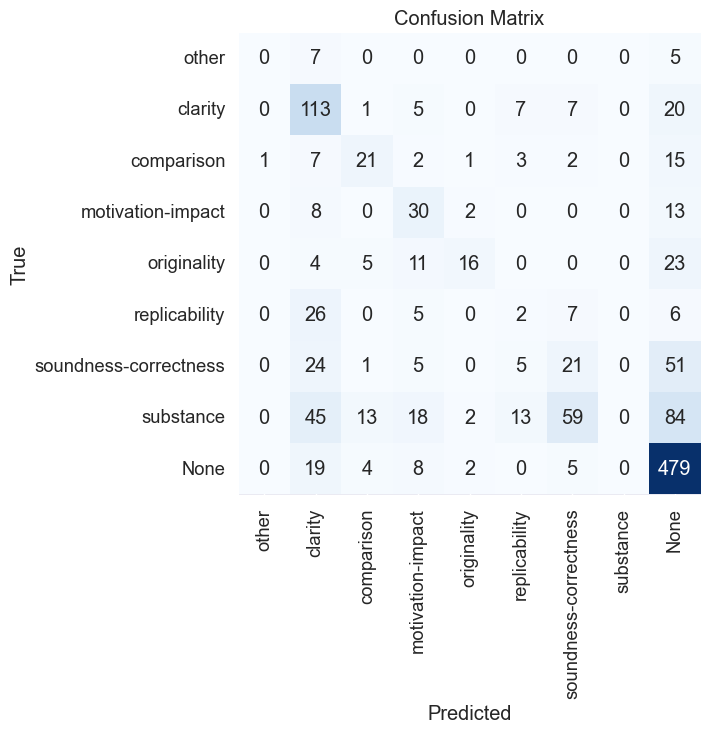

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

pred = []
for v, y in zip(test_texts, test_labels):
    #print(predict_category(v), "true: ", y)
    pred.append(predict_category(v))


confusion = confusion_matrix(test_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"], 
yticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
confusion = confusion_matrix(train_labels, pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"], 
yticklabels=["other", "clarity", "comparison", "motivation-impact", "originality", "replicability", "soundness-correctness",  "substance", "None"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [9616, 1233]

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, pred)
print('Accuracy:', accuracy)


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, pred, average='weighted')
recall = recall_score(test_labels, pred, average='weighted')
f1 = f1_score(test_labels, pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

Accuracy: 0.5531224655312247
Precision: 0.4328449182487211
Recall: 0.5531224655312247
F1-Score: 0.47547507236204617


c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, pred)
print('Accuracy:', accuracy)


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, pred, average='weighted')
recall = recall_score(test_labels, pred, average='weighted')
f1 = f1_score(test_labels, pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

Accuracy: 0.5109489051094891
Precision: 0.6467502680154954
Recall: 0.5109489051094891
F1-Score: 0.5277915086225922


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, pred)
print('Accuracy:', accuracy)


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, pred, average='weighted')
recall = recall_score(test_labels, pred, average='weighted')
f1 = f1_score(test_labels, pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

Accuracy: 0.5109489051094891
Precision: 0.6467502680154954
Recall: 0.5109489051094891
F1-Score: 0.5277915086225922


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
import numpy as np


# Umwandlung in NumPy Arrays (falls noch nicht)
test_labels = np.array(test_labels)
pred = np.array(pred)

# Accuracy und Precision pro Klasse berechnen
unique_classes = np.unique(test_labels)

# Initialisiere Dictionaries für die Ergebnisse
accuracy_per_class = {}
precision_per_class = {}

for cls in unique_classes:
    # Filtere die Instanzen für die aktuelle Klasse
    true_positive = np.sum((test_labels == cls) & (pred == cls))
    total_class_instances = np.sum(test_labels == cls)
    
    # Accuracy für diese Klasse
    accuracy_per_class[cls] = true_positive / total_class_instances
    
    # Precision für diese Klasse
    precision_per_class[cls] = precision_score(test_labels, pred, labels=[cls], average=None)[0]

# Ergebnisse ausgeben
print("Accuracy per class:")
for cls, acc in accuracy_per_class.items():
    print(f"Class {cls}: {acc:.2f}")

print("\nPrecision per class:")
for cls, prec in precision_per_class.items():
    print(f"Class {cls}: {prec:.2f}")

# Zusätzliche detaillierte Metriken für alle Klassen
print("\nClassification Report:")
print(classification_report(test_labels, pred, target_names=[f"Class {cls}" for cls in unique_classes]))


Accuracy per class:
Class 0: 0.00
Class 1: 0.74
Class 2: 0.40
Class 3: 0.57
Class 4: 0.27
Class 5: 0.04
Class 6: 0.20
Class 7: 0.00
Class 8: 0.93

Precision per class:
Class 0: 0.00
Class 1: 0.45
Class 2: 0.47
Class 3: 0.36
Class 4: 0.70
Class 5: 0.07
Class 6: 0.21
Class 7: 0.00
Class 8: 0.69

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        12
     Class 1       0.45      0.74      0.56       153
     Class 2       0.47      0.40      0.43        52
     Class 3       0.36      0.57      0.44        53
     Class 4       0.70      0.27      0.39        59
     Class 5       0.07      0.04      0.05        46
     Class 6       0.21      0.20      0.20       107
     Class 7       0.00      0.00      0.00       234
     Class 8       0.69      0.93      0.79       517

    accuracy                           0.55      1233
   macro avg       0.33      0.35      0.32      1233
weighted avg       0.43      0.5

c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classificati